In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4361801477148854504, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10682257155666184787
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13302844956741889342
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15956099072
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15040095386883325804
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [ ]:
import tensorflow as tf

print(tf.__version__)

2.2.0-rc3


In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()                   
drive = GoogleDrive(gauth)

link='https://drive.google.com/open?id=1NuD8u9E_gSdr9wgSu3hJXm9PV7jLtLaY'

fluff, id = link.split('=')
print (id)

1NuD8u9E_gSdr9wgSu3hJXm9PV7jLtLaY


In [ ]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('asl-alphabet.zip')

In [ ]:
!unzip asl-alphabet.zip

Streaming output truncated to the last 5000 lines.
  inflating: asl-alphabet/valid/L/L2043.jpg  
  inflating: asl-alphabet/valid/L/L2051.jpg  
  inflating: asl-alphabet/valid/L/L2064.jpg  
  inflating: asl-alphabet/valid/L/L2077.jpg  
  inflating: asl-alphabet/valid/L/L209.jpg  
  inflating: asl-alphabet/valid/L/L2093.jpg  
  inflating: asl-alphabet/valid/L/L2100.jpg  
  inflating: asl-alphabet/valid/L/L2105.jpg  
  inflating: asl-alphabet/valid/L/L211.jpg  
  inflating: asl-alphabet/valid/L/L2116.jpg  
  inflating: asl-alphabet/valid/L/L2119.jpg  
  inflating: asl-alphabet/valid/L/L2120.jpg  
  inflating: asl-alphabet/valid/L/L2128.jpg  
  inflating: asl-alphabet/valid/L/L2156.jpg  
  inflating: asl-alphabet/valid/L/L2159.jpg  
  inflating: asl-alphabet/valid/L/L216.jpg  
  inflating: asl-alphabet/valid/L/L2186.jpg  
  inflating: asl-alphabet/valid/L/L219.jpg  
  inflating: asl-alphabet/valid/L/L2193.jpg  
  inflating: asl-alphabet/valid/L/L2206.jpg  
  inflating: asl-alphabet/valid/L

In [ ]:
cd ..

/content/asl-alphabet


In [ ]:
# Preparing ImageDataGenerator object for training the model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras

IMAGE_SIZE = 200
BATCH_SIZE = 64

data_generator = ImageDataGenerator(
    samplewise_center=True, 
    samplewise_std_normalization=True,
    brightness_range=[0.8, 1.0],
    zoom_range=[1.0, 1.2],
)


train_path = 'train/';
valid_path = 'valid/';
test_path = 'test/';
train_batches = data_generator.flow_from_directory(train_path,target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True, seed=13,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")

valid_batches = data_generator.flow_from_directory(valid_path, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True, seed=13,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, )
                                   
test_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input)
              .flow_from_directory(test_path,target_size=(200,200),batch_size=2048,shuffle=False)


Using TensorFlow backend.


Found 69600 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.
Found 8728 images belonging to 29 classes.


In [ ]:
train_batches.class_indices.keys()

dict_keys(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space'])

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-03-01 08:57:12--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.31.128, 2607:f8b0:400c:c15::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/content/inception_ 100%[===================>]  83.84M   105MB/s    in 0.8s    

2020-03-01 08:57:13 (105 MB/s) - ‘/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
# Loading inception v3 network for transfer learning
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.applications.inception_v3 import InceptionV3

inception_v3_model = InceptionV3(
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), 
    include_top = False, 
    weights = 'imagenet'
)


# Enabling the top 2 inception blocks to train
for layer in inception_v3_model.layers[:4]:
    layer.trainable = False
for layer in inception_v3_model.layers[4:]:
    layer.trainable = True
    
# Checking model summary to pick a layer (if required)
inception_v3_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 99, 99, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 9

In [ ]:
# Choosing the output layer to be merged with our FC layers (if required)
#inception_output_layer = inception_v3_model.get_layer('mixed7')
#print('Inception model output shape:', inception_output_layer.output_shape)

#inception_output = inception_v3_model.output

Inception model output shape: (None, 10, 10, 768)


In [ ]:
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

x = layers.GlobalAveragePooling2D()(inception_output)
x = layers.Dense(1024, activation='relu')(x)                 
x = layers.Dense(29, activation='softmax')(x)           

model = Model(inception_v3_model.input, x) 

model.compile(
    optimizer=SGD(lr=0.0001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 99, 99, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 99, 99, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
# Creating a callback to stop model training after reaching a threshold accuracy

LOSS_THRESHOLD = 0.2
ACCURACY_THRESHOLD = 0.95

class ModelCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_loss') <= LOSS_THRESHOLD and logs.get('val_acc') >= ACCURACY_THRESHOLD:
      print("\nReached", ACCURACY_THRESHOLD * 100, "accuracy, Stopping!")
      self.model.stop_training = True

callback = ModelCallback()

In [ ]:

history = model.fit_generator(
    train_batches,
    validation_data=valid_batches,
    steps_per_epoch=100,
    validation_steps=50,
    epochs=50,
    callbacks=[callback]
)

Epoch 1/50
100/100 [==============================] - 125s 1s/step - loss: 3.3920 - acc: 0.0548 - val_loss: 3.3994 - val_acc: 0.0528
Epoch 2/50
100/100 [==============================] - 103s 1s/step - loss: 3.1565 - acc: 0.1550 - val_loss: 3.1563 - val_acc: 0.1325
Epoch 3/50
100/100 [==============================] - 102s 1s/step - loss: 2.9317 - acc: 0.3067 - val_loss: 2.9863 - val_acc: 0.2231
Epoch 4/50
100/100 [==============================] - 100s 1s/step - loss: 2.6586 - acc: 0.4614 - val_loss: 2.7591 - val_acc: 0.3428
Epoch 5/50
100/100 [==============================] - 101s 1s/step - loss: 2.3434 - acc: 0.5809 - val_loss: 2.5299 - val_acc: 0.4325
Epoch 6/50
100/100 [==============================] - 102s 1s/step - loss: 2.0103 - acc: 0.6916 - val_loss: 2.2546 - val_acc: 0.5350
Epoch 7/50
100/100 [==============================] - 102s 1s/step - loss: 1.6911 - acc: 0.7650 - val_loss: 1.9928 - val_acc: 0.6322
Epoch 8/50
100/100 [==============================] - 103s 1s/step - 

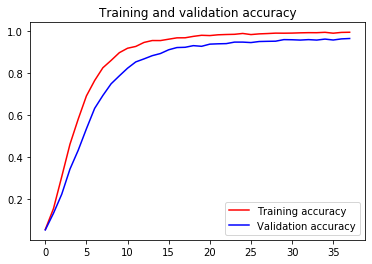

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

<Figure size 432x288 with 0 Axes>

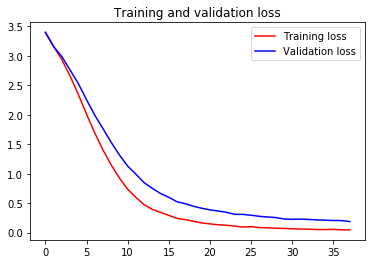

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

In [ ]:
test_labels = test_batches.classes;
test_batches.class_indices;

prediction = model.predict_generator(test_batches,steps =5);
prediction = prediction.argmax(axis =1);
prediction.size

8728

0.9899175068744271
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       301
           1       1.00      1.00      1.00       301
           2       1.00      1.00      1.00       301
           3       1.00      1.00      1.00       301
           4       0.98      0.99      0.99       301
           5       1.00      1.00      1.00       301
           6       1.00      1.00      1.00       301
           7       1.00      0.98      0.99       301
           8       0.99      1.00      1.00       301
           9       0.98      0.99      0.99       301
          10       1.00      0.97      0.99       301
          11       1.00      0.99      1.00       301
          12       0.97      0.98      0.98       301
          13       0.98      0.98      0.98       301
          14       1.00      1.00      1.00       301
          15       0.99      1.00      1.00       301
          16       0.99      0.99      0.99       301
        

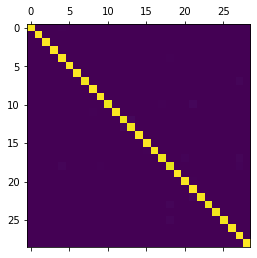

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print(accuracy_score(test_labels,prediction));
print(classification_report(test_labels,prediction));
cm_train = confusion_matrix(test_labels,prediction);
plt.matshow(cm_train);

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()                   
drive = GoogleDrive(gauth)

model.save('asl_inception_3_mod_b_backup.h5')
model_file = drive.CreateFile({'title' : 'asl_inception_3_mod_b_backup.h5'})   
model_file.SetContentFile('asl_inception_3_mod_b_backup.h5')    
model_file.Upload()

# download to google drive                      
drive.CreateFile({'id': model_file.get('id')})

GoogleDriveFile({'id': '1z41yLVYj5-485RaSmQPirrQBSaPm1-7Z'})

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving asl-alphabet-test_seperate.zip to asl-alphabet-test_seperate.zip


In [ ]:
!unzip asl-alphabet-test_seperate

Archive:  asl-alphabet-test_seperate.zip
   creating: asl-alphabet-test_seperate/A/
  inflating: asl-alphabet-test_seperate/A/A0001_test.jpg  
  inflating: asl-alphabet-test_seperate/A/A0002_test.jpg  
  inflating: asl-alphabet-test_seperate/A/A0003_test.jpg  
  inflating: asl-alphabet-test_seperate/A/A0004_test.jpg  
  inflating: asl-alphabet-test_seperate/A/A0005_test.jpg  
  inflating: asl-alphabet-test_seperate/A/A0006_test.jpg  
  inflating: asl-alphabet-test_seperate/A/A0007_test.jpg  
  inflating: asl-alphabet-test_seperate/A/A0008_test.jpg  
  inflating: asl-alphabet-test_seperate/A/A0009_test.jpg  
  inflating: asl-alphabet-test_seperate/A/A0010_test.jpg  
  inflating: asl-alphabet-test_seperate/A/A0011_test.jpg  
  inflating: asl-alphabet-test_seperate/A/A0012_test.jpg  
  inflating: asl-alphabet-test_seperate/A/A0013_test.jpg  
  inflating: asl-alphabet-test_seperate/A/A0014_test.jpg  
  inflating: asl-alphabet-test_seperate/A/A0015_test.jpg  
  inflating: asl-alphabet-test_

In [ ]:
ls


asl-alphabet-test_seperate/     asl_inception_3_mod_b_backup.h5  test/   valid/
asl-alphabet-test_seperate.zip  asl_inception_3_mod_b.h5         train/


In [ ]:
test_batches_2 = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory("asl-alphabet-test_seperate",
                                                                                                                              target_size=(200,200),batch_size=870,shuffle=False)

Found 870 images belonging to 29 classes.


In [ ]:
test_labels = test_batches_2.classes;
test_batches_2.class_indices;

prediction_2 = model.predict_generator(test_batches_2);
prediction_2 = prediction_2.argmax(axis =1);

prediction_2.size

870

0.44022988505747124
              precision    recall  f1-score   support

           0       0.38      0.17      0.23        30
           1       0.65      0.43      0.52        30
           2       0.70      0.23      0.35        30
           3       0.93      0.43      0.59        30
           4       0.50      0.13      0.21        30
           5       0.32      0.23      0.27        30
           6       0.40      0.47      0.43        30
           7       0.59      0.87      0.70        30
           8       1.00      0.20      0.33        30
           9       0.32      0.60      0.42        30
          10       0.56      0.47      0.51        30
          11       1.00      0.47      0.64        30
          12       0.73      0.37      0.49        30
          13       0.61      0.57      0.59        30
          14       0.54      0.50      0.52        30
          15       0.64      0.23      0.34        30
          16       0.58      0.83      0.68        30
       

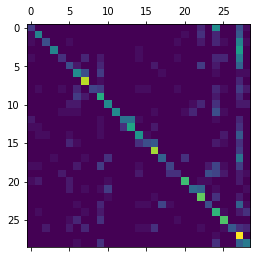

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print(accuracy_score(test_labels,prediction_2));
print(classification_report(test_labels,prediction_2));
cm_train = confusion_matrix(test_labels,prediction_2);
plt.matshow(cm_train);